## Preprocesamiento de Datos - Pruebas Saber Pro
#
# Este notebook contiene el proceso completo de preprocesamiento del dataset
# de entrenamiento para la competencia de Kaggle "UDEA AI 4 – Pruebas Saber Pro Colombia".
#
# **Objetivos:**
# 1. Cargar y explorar el dataset
# 2. Limpiar valores faltantes
# 3. Transformar variables categóricas y numéricas
# 4. Codificar variables para modelado
# 5. Exportar dataset preprocesado

## 1. Importación de librerías

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Configuración de visualización
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Librerías importadas correctamente")

Librerías importadas correctamente


## 2. Carga del dataset

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '.'
!chmod 600 ./kaggle.json
!kaggle competitions download -c udea-ai-4-eng-20252-pruebas-saber-pro-colombia

!unzip udea*.zip > /dev/null

df = pd.read_csv("train.csv")

print(f"Dataset cargado: {df.shape[0]:,} filas × {df.shape[1]} columnas")

  0% 0.00/29.9M [00:00<?, ?B/s]
100% 29.9M/29.9M [00:00<00:00, 543MB/s]
Dataset cargado: 692,500 filas × 21 columnas


## 3. Inspección inicial

In [ ]:
print("=" * 60)
print("INFORMACIÓN GENERAL DEL DATASET")
print("=" * 60)
df.info()

INFORMACIÓN GENERAL DEL DATASET
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 692500 entries, 0 to 692499
Data columns (total 21 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   ID                           692500 non-null  int64  
 1   PERIODO_ACADEMICO            692500 non-null  int64  
 2   E_PRGM_ACADEMICO             692500 non-null  object 
 3   E_PRGM_DEPARTAMENTO          692500 non-null  object 
 4   E_VALORMATRICULAUNIVERSIDAD  686213 non-null  object 
 5   E_HORASSEMANATRABAJA         661643 non-null  object 
 6   F_ESTRATOVIVIENDA            660363 non-null  object 
 7   F_TIENEINTERNET              665871 non-null  object 
 8   F_EDUCACIONPADRE             669322 non-null  object 
 9   F_TIENELAVADORA              652727 non-null  object 
 10  F_TIENEAUTOMOVIL             648877 non-null  object 
 11  E_PRIVADO_LIBERTAD           692500 non-null  object 
 12  E_PAGOMATRICULAPROPIO     

In [ ]:
print("\nPrimeras 5 filas del dataset:")
df.head()


Primeras 5 filas del dataset:


,ID,PERIODO_ACADEMICO,E_PRGM_ACADEMICO,E_PRGM_DEPARTAMENTO,E_VALORMATRICULAUNIVERSIDAD,E_HORASSEMANATRABAJA,F_ESTRATOVIVIENDA,F_TIENEINTERNET,F_EDUCACIONPADRE,F_TIENELAVADORA,...,E_PRIVADO_LIBERTAD,E_PAGOMATRICULAPROPIO,F_TIENECOMPUTADOR,F_TIENEINTERNET.1,F_EDUCACIONMADRE,RENDIMIENTO_GLOBAL,INDICADOR_1,INDICADOR_2,INDICADOR_3,INDICADOR_4
0,904256,20212,ENFERMERIA,BOGOTÁ,Entre 5.5 millones y menos de 7 millones,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica incompleta,Si,...,N,No,Si,Si,Postgrado,medio-alto,0.322,0.208,0.310,0.267
1,645256,20212,DERECHO,ATLANTICO,Entre 2.5 millones y menos de 4 millones,0,Estrato 3,No,Técnica o tecnológica completa,Si,...,N,No,Si,No,Técnica o tecnológica incompleta,bajo,0.311,0.215,0.292,0.264
2,308367,20203,MERCADEO Y PUBLICIDAD,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 3,Si,Secundaria (Bachillerato) completa,Si,...,N,No,No,Si,Secundaria (Bachillerato) completa,bajo,0.297,0.214,0.305,0.264
3,470353,20195,ADMINISTRACION DE EMPRESAS,SANTANDER,Entre 4 millones y menos de 5.5 millones,0,Estrato 4,Si,No sabe,Si,...,N,No,Si,Si,Secundaria (Bachillerato) completa,alto,0.485,0.172,0.252,0.190
4,989032,20212,PSICOLOGIA,ANTIOQUIA,Entre 2.5 millones y menos de 4 millones,Entre 21 y 30 horas,Estrato 3,Si,Primaria completa,Si,...,N,No,Si,Si,Primaria completa,medio-bajo,0.316,0.232,0.285,0.294


In [ ]:
print("\nEstadísticas descriptivas:")
df.describe()


Estadísticas descriptivas:


,ID,PERIODO_ACADEMICO,INDICADOR_1,INDICADOR_2,INDICADOR_3,INDICADOR_4
count,692500.000000,692500.000000,692500.000000,692500.000000,692500.000000,692500.000000
mean,494606.130576,20198.366679,0.268629,0.259996,0.262087,0.262903
std,285585.209455,10.535037,0.122130,0.093480,0.058862,0.067944
min,1.000000,20183.000000,0.000000,0.000000,0.000000,0.000000
25%,247324.750000,20195.000000,0.203000,0.212000,0.254000,0.255000
50%,494564.500000,20195.000000,0.240000,0.271000,0.276000,0.285000
75%,741782.500000,20203.000000,0.314000,0.309000,0.293000,0.303000
max,989286.000000,20213.000000,0.657000,0.487000,0.320000,0.332000


## 4. Análisis de valores faltantes en todo el dataset

ANÁLISIS COMPLETO DE VALORES FALTANTES

Columnas con valores faltantes: 11/21

Top 10 columnas con más valores faltantes:
                  Columna  Valores_Nulos  Porcentaje
10       F_TIENEAUTOMOVIL          43623        6.30
9         F_TIENELAVADORA          39773        5.74
13      F_TIENECOMPUTADOR          38103        5.50
6       F_ESTRATOVIVIENDA          32137        4.64
5    E_HORASSEMANATRABAJA          30857        4.46
14      F_TIENEINTERNET.1          26629        3.85
7         F_TIENEINTERNET          26629        3.85
15       F_EDUCACIONMADRE          23664        3.42
8        F_EDUCACIONPADRE          23178        3.35
12  E_PAGOMATRICULAPROPIO           6498        0.94


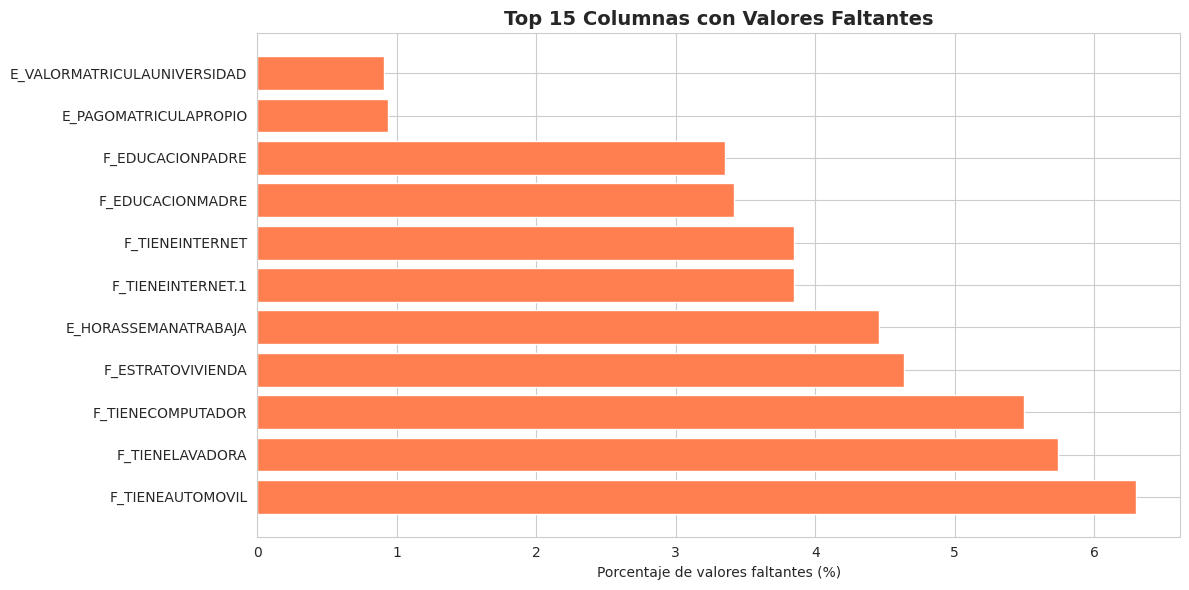

In [ ]:
print("=" * 80)
print("ANÁLISIS COMPLETO DE VALORES FALTANTES")
print("=" * 80)

# Conteo de valores nulos por columna
nulos_df = pd.DataFrame({
    'Columna': df.columns,
    'Valores_Nulos': df.isnull().sum().values,
    'Porcentaje': (df.isnull().sum().values / len(df) * 100).round(2)
})
nulos_df = nulos_df[nulos_df['Valores_Nulos'] > 0].sort_values('Porcentaje', ascending=False)

print(f"\nColumnas con valores faltantes: {len(nulos_df)}/{len(df.columns)}")
print("\nTop 10 columnas con más valores faltantes:")
print(nulos_df.head(10))

# Visualización
if len(nulos_df) > 0:
    fig, ax = plt.subplots(figsize=(12, 6))
    top_nulos = nulos_df.head(15)
    ax.barh(range(len(top_nulos)), top_nulos['Porcentaje'], color='coral')
    ax.set_yticks(range(len(top_nulos)))
    ax.set_yticklabels(top_nulos['Columna'])
    ax.set_xlabel('Porcentaje de valores faltantes (%)')
    ax.set_title('Top 15 Columnas con Valores Faltantes', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

## 5. Selección de columnas para el modelo

Basándonos en el análisis exploratorio previo, seleccionamos las columnas más relevantes:


*   **E_VALORMATRICULAUNIVERSIDAD**: Valor de la matrícula (económico)
*   **F_EDUCACIONMADRE**: Nivel educativo de la madre (socioeconómico)
*   **RENDIMIENTO_GLOBAL**: Variable objetivo

In [ ]:
columnas_seleccionadas = [
    'E_VALORMATRICULAUNIVERSIDAD',
    'F_EDUCACIONMADRE',
    'RENDIMIENTO_GLOBAL'
]

columnas_faltantes = [col for col in columnas_seleccionadas if col not in df.columns]
if columnas_faltantes:
    print(f"ADVERTENCIA: Columnas no encontradas: {columnas_faltantes}")
else:
    print("Todas las columnas seleccionadas están disponibles\n")
    for col in columnas_seleccionadas:
        print(f"  • {col}")

z = df[columnas_seleccionadas].copy()
print(f"\nDataset reducido: {z.shape[0]:,} filas × {z.shape[1]} columnas")

Todas las columnas seleccionadas están disponibles

  • E_VALORMATRICULAUNIVERSIDAD
  • F_EDUCACIONMADRE
  • RENDIMIENTO_GLOBAL

Dataset reducido: 692,500 filas × 3 columnas


## 6. Exploración de las variables seleccionadas

In [ ]:
print("=" * 80)
print("EXPLORACIÓN DE VARIABLES SELECCIONADAS")
print("=" * 80)

for col in z.columns:
    print(f"\n{'='*40}")
    print(f"{col}")
    print(f"{'='*40}")
    print(f"Tipo de dato: {z[col].dtype}")
    print(f"Valores únicos: {z[col].nunique()}")
    print(f"Valores nulos: {z[col].isnull().sum()} ({z[col].isnull().sum()/len(z)*100:.2f}%)")

    if z[col].dtype == 'object':
        print(f"\nDistribución (top 10):")
        print(z[col].value_counts().head(10))

EXPLORACIÓN DE VARIABLES SELECCIONADAS

E_VALORMATRICULAUNIVERSIDAD
Tipo de dato: object
Valores únicos: 8
Valores nulos: 6287 (0.91%)

Distribución (top 10):
E_VALORMATRICULAUNIVERSIDAD
Entre 1 millón y menos de 2.5 millones      204048
Entre 2.5 millones y menos de 4 millones    127430
Menos de 500 mil                             80263
Entre 500 mil y menos de 1 millón            78704
Entre 4 millones y menos de 5.5 millones     69736
Más de 7 millones                            68014
Entre 5.5 millones y menos de 7 millones     38490
No pagó matrícula                            19528
Name: count, dtype: int64

F_EDUCACIONMADRE
Tipo de dato: object
Valores únicos: 12
Valores nulos: 23664 (3.42%)

Distribución (top 10):
F_EDUCACIONMADRE
Secundaria (Bachillerato) completa      141744
Primaria incompleta                      99420
Técnica o tecnológica completa           89542
Educación profesional completa           85326
Secundaria (Bachillerato) incompleta     81012
Primaria complet

## 7. Limpieza de valores faltantes

In [ ]:
print("\nLIMPIEZA DE VALORES FALTANTES")
print("=" * 80)

print("\nValores nulos ANTES de la limpieza:")
print(z.isnull().sum())

for col in ['E_VALORMATRICULAUNIVERSIDAD', 'F_EDUCACIONMADRE']:
    if col in z.columns:
        cantidad_nulos = z[col].isnull().sum()
        z.loc[z[col].isna(), col] = 'no info'
        print(f"\n{col}: {cantidad_nulos} valores nulos reemplazados por 'no info'")

print("\nValores nulos DESPUÉS de la limpieza:")
print(z.isnull().sum())

if z.isnull().sum().sum() == 0:
    print("\n¡Limpieza completada! No quedan valores nulos.")
else:
    print(f"\nAún quedan {z.isnull().sum().sum()} valores nulos")


LIMPIEZA DE VALORES FALTANTES

Valores nulos ANTES de la limpieza:
E_VALORMATRICULAUNIVERSIDAD     6287
F_EDUCACIONMADRE               23664
RENDIMIENTO_GLOBAL                 0
dtype: int64

E_VALORMATRICULAUNIVERSIDAD: 6287 valores nulos reemplazados por 'no info'

F_EDUCACIONMADRE: 23664 valores nulos reemplazados por 'no info'

Valores nulos DESPUÉS de la limpieza:
E_VALORMATRICULAUNIVERSIDAD    0
F_EDUCACIONMADRE               0
RENDIMIENTO_GLOBAL             0
dtype: int64

¡Limpieza completada! No quedan valores nulos.


## 8. Transformación de E_VALORMATRICULAUNIVERSIDAD


TRANSFORMACIÓN DE VALOR DE MATRÍCULA

Categorías originales:
E_VALORMATRICULAUNIVERSIDAD
Entre 1 millón y menos de 2.5 millones      204048
Entre 2.5 millones y menos de 4 millones    127430
Entre 4 millones y menos de 5.5 millones     69736
Entre 5.5 millones y menos de 7 millones     38490
Entre 500 mil y menos de 1 millón            78704
Menos de 500 mil                             80263
Más de 7 millones                            68014
No pagó matrícula                            19528
no info                                       6287
Name: count, dtype: int64

ADVERTENCIA: Categorías sin mapear: {'No pagó matrícula'}

Estadísticas después de la transformación:
count    672972.000000
mean          2.912393
std           2.359979
min          -1.000000
25%           1.750000
50%           1.750000
75%           4.750000
max           8.000000
Name: E_VALORMATRICULAUNIVERSIDAD, dtype: float64


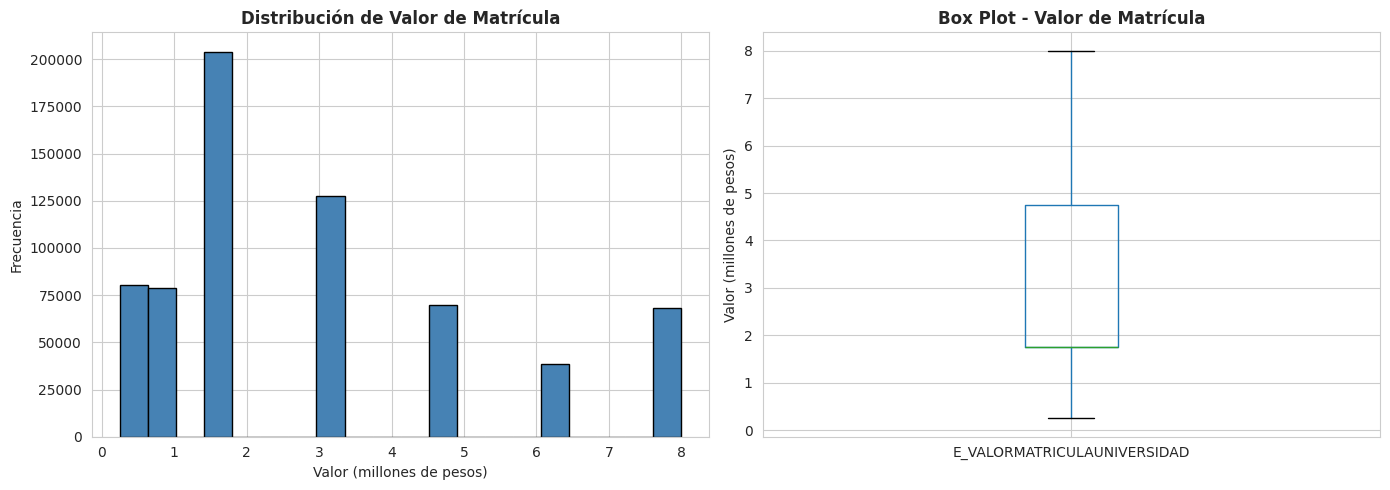


PREPROCESAMIENTO DEL DATASET DE PRUEBA PARA SUBMISSION
Shape of loaded test dataframe: (296786, 2)


,F_EDUCACIONMADRE,E_VALORMATRICULAUNIVERSIDAD
0,Primaria completa,Menos de 500 mil
1,Técnica o tecnológica completa,Entre 2.5 millones y menos de 4 millones
2,Secundaria (Bachillerato) completa,Entre 1 millón y menos de 2.5 millones
3,Primaria incompleta,Entre 1 millón y menos de 2.5 millones
4,Secundaria (Bachillerato) completa,Entre 2.5 millones y menos de 4 millones



Valores nulos en dataset de prueba después de reemplazo:
F_EDUCACIONMADRE               0
E_VALORMATRICULAUNIVERSIDAD    0
dtype: int64

Estadísticas de matrícula en test después de transformación:
count    288466.000000
mean          2.913260
std           2.358807
min          -1.000000
25%           1.750000
50%           1.750000
75%           4.750000
max           8.000000
Name: E_VALORMATRICULAUNIVERSIDAD, dtype: float64

Distribución de educación de la madre en test después de limpieza:
F_EDUCACIONMADRE
Secundaria (Bachillerato) completa      60649
Primaria incompleta                     42149
Técnica o tecnológica completa          38571
Educación profesional completa          36477
Secundaria (Bachillerato) incompleta    34566
Primaria completa                       24399
Postgrado                               20049
no info                                 12294
Técnica o tecnológica incompleta        11650
Educación profesional incompleta         9647
Ninguno               

,F_EDUCACIONMADRE__Educación profesional completa,F_EDUCACIONMADRE__Educación profesional incompleta,F_EDUCACIONMADRE__Ninguno,F_EDUCACIONMADRE__No Aplica,F_EDUCACIONMADRE__No sabe,F_EDUCACIONMADRE__Postgrado,F_EDUCACIONMADRE__Primaria completa,F_EDUCACIONMADRE__Primaria incompleta,F_EDUCACIONMADRE__Secundaria (Bachillerato) completa,F_EDUCACIONMADRE__Secundaria (Bachillerato) incompleta,F_EDUCACIONMADRE__Técnica o tecnológica completa,F_EDUCACIONMADRE__Técnica o tecnológica incompleta,F_EDUCACIONMADRE__no info
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0



Dataset de prueba procesado: 296,786 filas × 14 columnas


,F_EDUCACIONMADRE__Educación profesional completa,F_EDUCACIONMADRE__Educación profesional incompleta,F_EDUCACIONMADRE__Ninguno,F_EDUCACIONMADRE__No Aplica,F_EDUCACIONMADRE__No sabe,F_EDUCACIONMADRE__Postgrado,F_EDUCACIONMADRE__Primaria completa,F_EDUCACIONMADRE__Primaria incompleta,F_EDUCACIONMADRE__Secundaria (Bachillerato) completa,F_EDUCACIONMADRE__Secundaria (Bachillerato) incompleta,F_EDUCACIONMADRE__Técnica o tecnológica completa,F_EDUCACIONMADRE__Técnica o tecnológica incompleta,F_EDUCACIONMADRE__no info,E_VALORMATRICULAUNIVERSIDAD
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.25
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.75
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.75
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.25


In [ ]:
print("\nTRANSFORMACIÓN DE VALOR DE MATRÍCULA")
print("=" * 80)

print("\nCategorías originales:")
print(z['E_VALORMATRICULAUNIVERSIDAD'].value_counts().sort_index())

cmap = {
    'Menos de 500 mil': 0.25,
    'Entre 500 mil y menos de 1 millón': 0.75,
    'Entre 1 millón y menos de 2.5 millones': 1.75,
    'Entre 2.5 millones y menos de 4 millones': 3.25,
    'Entre 4 millones y menos de 5.5 millones': 4.75,
    'Entre 5.5 millones y menos de 7 millones': 6.25,
    'Más de 7 millones': 8.0,
    'No Pagó matrícula': 0.0,
    'no info': -1.0
}

categorias_sin_mapear = set(z['E_VALORMATRICULAUNIVERSIDAD'].unique()) - set(cmap.keys())
if categorias_sin_mapear:
    print(f"\nADVERTENCIA: Categorías sin mapear: {categorias_sin_mapear}")
else:
    print("\nTodas las categorías tienen mapeo definido")

z['E_VALORMATRICULAUNIVERSIDAD'] = z['E_VALORMATRICULAUNIVERSIDAD'].map(cmap)

print("\nEstadísticas después de la transformación:")
print(z['E_VALORMATRICULAUNIVERSIDAD'].describe())

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

z[z['E_VALORMATRICULAUNIVERSIDAD'] >= 0]['E_VALORMATRICULAUNIVERSIDAD'].hist(
    bins=20, ax=axes[0], color='steelblue', edgecolor='black'
)
axes[0].set_title('Distribución de Valor de Matrícula', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Valor (millones de pesos)')
axes[0].set_ylabel('Frecuencia')

z[z['E_VALORMATRICULAUNIVERSIDAD'] >= 0].boxplot(
    column='E_VALORMATRICULAUNIVERSIDAD', ax=axes[1]
)
axes[1].set_title('Box Plot - Valor de Matrícula', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Valor (millones de pesos)')

plt.tight_layout()
plt.show()

# Load and preprocess test data for submission
print("\nPREPROCESAMIENTO DEL DATASET DE PRUEBA PARA SUBMISSION")
print("=" * 80)

# Carga del dataset de prueba
zt = pd.read_csv("test.csv")
zt_ids = zt['ID'].values
zt = zt[['F_EDUCACIONMADRE', 'E_VALORMATRICULAUNIVERSIDAD']]
print("Shape of loaded test dataframe:", zt.shape)
display(zt.head())

# Reemplazo de valores faltantes por 'no info'
zt.loc[zt['F_EDUCACIONMADRE'].isna(), 'F_EDUCACIONMADRE'] = 'no info'
zt.loc[zt['E_VALORMATRICULAUNIVERSIDAD'].isna(), 'E_VALORMATRICULAUNIVERSIDAD'] = 'no info'

print("\nValores nulos en dataset de prueba después de reemplazo:")
print(zt.isnull().sum())

# Conversión de matrícula a valores numéricos usando el mismo mapeo
zt['E_VALORMATRICULAUNIVERSIDAD'] = zt['E_VALORMATRICULAUNIVERSIDAD'].map(cmap)

print("\nEstadísticas de matrícula en test después de transformación:")
print(zt['E_VALORMATRICULAUNIVERSIDAD'].describe())

# Limpieza de categorías ambiguas en educación de la madre usando el mismo mapeo
categorias_ambiguas = ['No sabe', 'No Aplica']
zt['F_EDUCACIONMADRE'] = zt['F_EDUCACIONMADRE'].apply(
    lambda x: 'no info' if x in categorias_ambiguas else x
)

print("\nDistribución de educación de la madre en test después de limpieza:")
print(zt['F_EDUCACIONMADRE'].value_counts())

# Codificación one-hot de educación de la madre usando el mismo diccionario
# Ensure all categories from training are present in test one-hot
educacion_vals_train = sorted(z['F_EDUCACIONMADRE'].unique()) # Use categories from training data
educacion_onehot_dict_train = {
    val: np.eye(len(educacion_vals_train))[i]
    for i, val in enumerate(educacion_vals_train)
}


# Apply one-hot encoding to test data
educacion_onehot_array_test = np.array([
    educacion_onehot_dict_train.get(val, np.zeros(len(educacion_vals_train))) # Handle unseen categories gracefully
    for val in zt['F_EDUCACIONMADRE']
])

educacion_onehot_df_test = pd.DataFrame(
    educacion_onehot_array_test,
    columns=[f"F_EDUCACIONMADRE__{val}" for val in educacion_vals_train],
    index=zt.index
)

print(f"\nDataFrame One-Hot para test creado: {educacion_onehot_df_test.shape[0]:,} filas × {educacion_onehot_df_test.shape[1]} columnas")
display(educacion_onehot_df_test.head())


# Integración del one-hot al dataset de prueba y eliminación de la columna original
zt_procesado_test = pd.concat([educacion_onehot_df_test, zt[['E_VALORMATRICULAUNIVERSIDAD']]], axis=1)

print(f"\nDataset de prueba procesado: {zt_procesado_test.shape[0]:,} filas × {zt_procesado_test.shape[1]} columnas")

# Vista final del dataset de prueba procesado
display(zt_procesado_test.head())

## 9. Limpieza de F_EDUCACIONMADRE

In [ ]:
print("\nLIMPIEZA DE EDUCACIÓN DE LA MADRE")
print("=" * 80)

print("\nDistribución ANTES de la limpieza:")
print(z['F_EDUCACIONMADRE'].value_counts())

categorias_ambiguas = ['No sabe', 'No Aplica']

z['F_EDUCACIONMADRE'] = z['F_EDUCACIONMADRE'].apply(
    lambda x: 'no info' if x in categorias_ambiguas else x
)

print("\nDistribución DESPUÉS de la limpieza:")
print(z['F_EDUCACIONMADRE'].value_counts())

categorias_finales = sorted(z['F_EDUCACIONMADRE'].unique())
print(f"\nTotal de categorías únicas: {len(categorias_finales)}")
print("\nCategorías finales:")
for i, cat in enumerate(categorias_finales, 1):
    count = (z['F_EDUCACIONMADRE'] == cat).sum()
    pct = count / len(z) * 100
    print(f"  {i:2d}. {cat:45s} - {count:7,} ({pct:5.2f}%)")


LIMPIEZA DE EDUCACIÓN DE LA MADRE

Distribución ANTES de la limpieza:
F_EDUCACIONMADRE
Secundaria (Bachillerato) completa      141744
Primaria incompleta                      99420
Técnica o tecnológica completa           89542
Educación profesional completa           85326
Secundaria (Bachillerato) incompleta     81012
Primaria completa                        56125
Postgrado                                46246
Técnica o tecnológica incompleta         27533
no info                                  23664
Educación profesional incompleta         22470
Ninguno                                  14483
No sabe                                   3017
No Aplica                                 1918
Name: count, dtype: int64

Distribución DESPUÉS de la limpieza:
F_EDUCACIONMADRE
Secundaria (Bachillerato) completa      141744
Primaria incompleta                      99420
Técnica o tecnológica completa           89542
Educación profesional completa           85326
Secundaria (Bachillerato) incomp

## 10. Codificación One-Hot de F_EDUCACIONMADRE

In [ ]:
print("\nCODIFICACIÓN ONE-HOT DE EDUCACIÓN DE LA MADRE")
print("=" * 80)

educacion_vals = sorted(z['F_EDUCACIONMADRE'].unique())
print(f"\nNúmero de categorías: {len(educacion_vals)}")

educacion_onehot_dict = {
    val: np.eye(len(educacion_vals))[i]
    for i, val in enumerate(educacion_vals)
}

print("\nDiccionario One-Hot creado")
print("\nEjemplo de codificación:")
ejemplo_cat = educacion_vals[0]
print(f"'{ejemplo_cat}' → {educacion_onehot_dict[ejemplo_cat]}")

print("\nAplicando codificación a todas las filas...")
educacion_onehot_array = np.array([
    educacion_onehot_dict[val]
    for val in z['F_EDUCACIONMADRE']
])

print(f"Array generado con shape: {educacion_onehot_array.shape}")

educacion_onehot_df = pd.DataFrame(
    educacion_onehot_array,
    columns=[f"F_EDUCACIONMADRE__{val}" for val in educacion_vals],
    index=z.index
)

print(f"DataFrame One-Hot creado: {educacion_onehot_df.shape[0]:,} filas × {educacion_onehot_df.shape[1]} columnas")

print("\nPrimeras 5 filas del encoding:")
print(educacion_onehot_df.head())

sumas = educacion_onehot_df.sum(axis=1)
if (sumas == 1).all():
    print("\nVerificación: Todas las filas suman 1 (One-Hot correcto)")
else:
    print(f"\nADVERTENCIA: {(sumas != 1).sum()} filas no suman 1")


CODIFICACIÓN ONE-HOT DE EDUCACIÓN DE LA MADRE

Número de categorías: 11

Diccionario One-Hot creado

Ejemplo de codificación:
'Educación profesional completa' → [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Aplicando codificación a todas las filas...
Array generado con shape: (692500, 11)
DataFrame One-Hot creado: 692,500 filas × 11 columnas

Primeras 5 filas del encoding:
   F_EDUCACIONMADRE__Educación profesional completa  \
0                                               0.0   
1                                               0.0   
2                                               0.0   
3                                               0.0   
4                                               0.0   

   F_EDUCACIONMADRE__Educación profesional incompleta  \
0                                                0.0    
1                                                0.0    
2                                                0.0    
3                                                0.0    
4                

## 11. Codificación ordinal de RENDIMIENTO_GLOBAL


CODIFICACIÓN DE LA VARIABLE OBJETIVO

Valores nulos en RENDIMIENTO_GLOBAL: 0 (0.00%)

Distribución ANTES de la codificación:
RENDIMIENTO_GLOBAL
alto          175619
bajo          172987
medio-bajo    172275
medio-alto    171619
Name: count, dtype: int64

Todas las categorías tienen mapeo definido

No se eliminaron filas

Distribución DESPUÉS de la codificación:
  0 (bajo        ): 172,987 (24.98%)
  1 (medio-bajo  ): 172,275 (24.88%)
  2 (medio-alto  ): 171,619 (24.78%)
  3 (alto        ): 175,619 (25.36%)


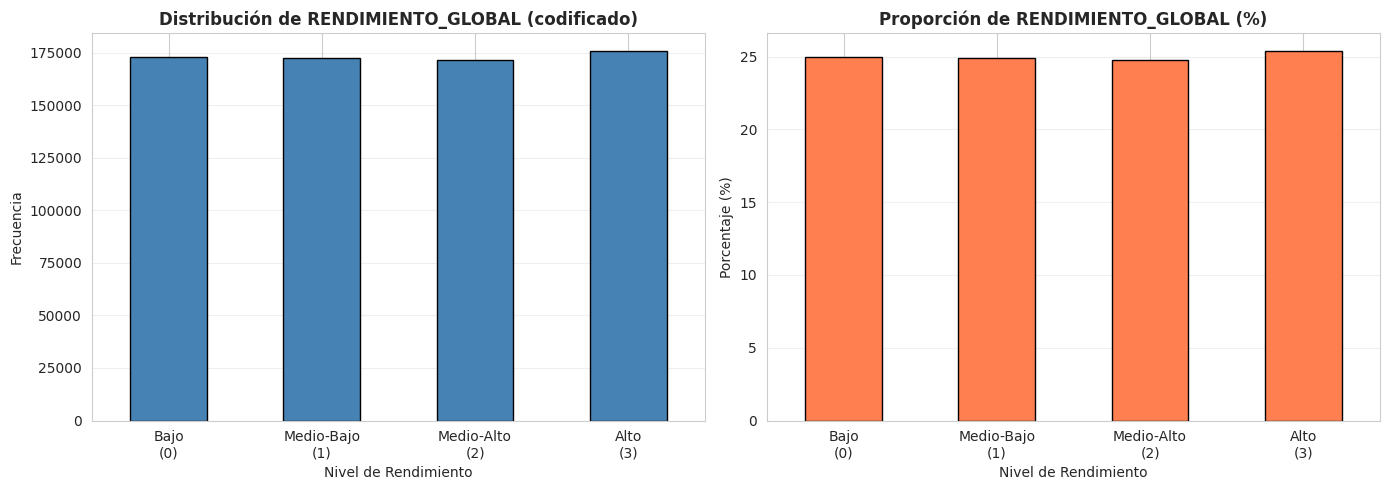

In [ ]:
print("\nCODIFICACIÓN DE LA VARIABLE OBJETIVO")
print("=" * 80)

nulos_antes = z['RENDIMIENTO_GLOBAL'].isnull().sum()
print(f"\nValores nulos en RENDIMIENTO_GLOBAL: {nulos_antes} ({nulos_antes/len(z)*100:.2f}%)")

print("\nDistribución ANTES de la codificación:")
print(z['RENDIMIENTO_GLOBAL'].value_counts())

if nulos_antes > 0:
    print(f"\nIMPORTANTE: Hay {nulos_antes} filas sin etiqueta de rendimiento.")
    print("   Estas filas serán ELIMINADAS ya que no podemos entrenar sin variable objetivo.")

rendimiento_map = {
    'bajo': 0,
    'medio-bajo': 1,
    'medio-alto': 2,
    'alto': 3
}

categorias_validas = z['RENDIMIENTO_GLOBAL'].dropna().unique()
categorias_sin_mapear = set(categorias_validas) - set(rendimiento_map.keys())
if categorias_sin_mapear:
    print(f"\nADVERTENCIA: Categorías sin mapear: {categorias_sin_mapear}")
else:
    print("\nTodas las categorías tienen mapeo definido")

z['RENDIMIENTO_GLOBAL'] = z['RENDIMIENTO_GLOBAL'].map(rendimiento_map)

filas_antes = len(z)
z = z.dropna(subset=['RENDIMIENTO_GLOBAL'])
filas_despues = len(z)
filas_eliminadas = filas_antes - filas_despues

if filas_eliminadas > 0:
    print(f"\nFilas eliminadas (sin etiqueta): {filas_eliminadas:,}")
    print(f"   Filas restantes: {filas_despues:,}")
else:
    print("\nNo se eliminaron filas")

print("\nDistribución DESPUÉS de la codificación:")
distribucion = z['RENDIMIENTO_GLOBAL'].value_counts().sort_index()
for nivel, count in distribucion.items():
    nivel_texto = {0: 'bajo', 1: 'medio-bajo', 2: 'medio-alto', 3: 'alto'}[int(nivel)]
    pct = count / len(z) * 100
    print(f"  {int(nivel)} ({nivel_texto:12s}): {count:7,} ({pct:5.2f}%)")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

distribucion.plot(kind='bar', ax=axes[0], color='steelblue', edgecolor='black')
axes[0].set_title('Distribución de RENDIMIENTO_GLOBAL (codificado)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Nivel de Rendimiento')
axes[0].set_ylabel('Frecuencia')
axes[0].set_xticklabels(['Bajo\n(0)', 'Medio-Bajo\n(1)', 'Medio-Alto\n(2)', 'Alto\n(3)'], rotation=0)
axes[0].grid(axis='y', alpha=0.3)

(distribucion / len(z) * 100).plot(kind='bar', ax=axes[1], color='coral', edgecolor='black')
axes[1].set_title('Proporción de RENDIMIENTO_GLOBAL (%)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Nivel de Rendimiento')
axes[1].set_ylabel('Porcentaje (%)')
axes[1].set_xticklabels(['Bajo\n(0)', 'Medio-Bajo\n(1)', 'Medio-Alto\n(2)', 'Alto\n(3)'], rotation=0)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 12. Integración del dataset preprocesado

In [ ]:
print("\nINTEGRACIÓN DE TODAS LAS TRANSFORMACIONES")
print("=" * 80)

# Ensure educacion_onehot_df aligns with the index of z after potential drops
educacion_onehot_df = educacion_onehot_df.loc[z.index]

z_procesado = pd.concat([
    educacion_onehot_df,
    z[['E_VALORMATRICULAUNIVERSIDAD', 'RENDIMIENTO_GLOBAL']].reset_index(drop=True)
], axis=1)

z_procesado = z_procesado.reset_index(drop=True)

# Fill remaining NaN values in E_VALORMATRICULAUNIVERSIDAD with -1.0
z_procesado['E_VALORMATRICULAUNIVERSIDAD'] = z_procesado['E_VALORMATRICULAUNIVERSIDAD'].fillna(-1.0)


columnas_features = sorted([col for col in z_procesado.columns if col != 'RENDIMIENTO_GLOBAL'])
z_procesado = z_procesado[columnas_features + ['RENDIMIENTO_GLOBAL']]

print(f"Dataset integrado: {z_procesado.shape[0]:,} filas × {z_procesado.shape[1]} columnas")

print("\nEstructura del dataset final:")
print(f"  • Features: {z_procesado.shape[1] - 1}")
print(f"  • Variable objetivo: 1 (RENDIMIENTO_GLOBAL)")
print(f"  • Total columnas: {z_procesado.shape[1]}")

print("\nColumnas del dataset procesado:")
for i, col in enumerate(z_procesado.columns, 1):
    tipo = 'TARGET' if col == 'RENDIMIENTO_GLOBAL' else 'FEATURE'
    print(f"  {i:2d}. [{tipo:7s}] {col}")

print("\nPrimeras 5 filas del dataset procesado:")
print(z_procesado.head())


INTEGRACIÓN DE TODAS LAS TRANSFORMACIONES
Dataset integrado: 692,500 filas × 13 columnas

Estructura del dataset final:
  • Features: 12
  • Variable objetivo: 1 (RENDIMIENTO_GLOBAL)
  • Total columnas: 13

Columnas del dataset procesado:
   1. [FEATURE] E_VALORMATRICULAUNIVERSIDAD
   2. [FEATURE] F_EDUCACIONMADRE__Educación profesional completa
   3. [FEATURE] F_EDUCACIONMADRE__Educación profesional incompleta
   4. [FEATURE] F_EDUCACIONMADRE__Ninguno
   5. [FEATURE] F_EDUCACIONMADRE__Postgrado
   6. [FEATURE] F_EDUCACIONMADRE__Primaria completa
   7. [FEATURE] F_EDUCACIONMADRE__Primaria incompleta
   8. [FEATURE] F_EDUCACIONMADRE__Secundaria (Bachillerato) completa
   9. [FEATURE] F_EDUCACIONMADRE__Secundaria (Bachillerato) incompleta
  10. [FEATURE] F_EDUCACIONMADRE__Técnica o tecnológica completa
  11. [FEATURE] F_EDUCACIONMADRE__Técnica o tecnológica incompleta
  12. [FEATURE] F_EDUCACIONMADRE__no info
  13. [TARGET ] RENDIMIENTO_GLOBAL

Primeras 5 filas del dataset procesado:
  

## 13. Verificación de consistencia

In [ ]:
print("\nVERIFICACIÓN FINAL DEL DATASET")
print("=" * 80)

nulos_final = z_procesado.isnull().sum().sum()
check1 = nulos_final == 0
print(f"\n1. Valores nulos: {nulos_final} {'✅' if check1 else '❌'}")

tipos_correctos = all(z_procesado.dtypes != 'object')
check2 = tipos_correctos
print(f"2. Todos los datos son numéricos: {'✅' if check2 else '❌'}")
if not check2:
    print("   Columnas no numéricas:")
    for col in z_procesado.columns:
        if z_procesado[col].dtype == 'object':
            print(f"     • {col}: {z_procesado[col].dtype}")

rango_ok = z_procesado['RENDIMIENTO_GLOBAL'].between(0, 3).all()
check3 = rango_ok
print(f"3. RENDIMIENTO_GLOBAL en rango [0,3]: {'✅' if check3 else '❌'}")
if not check3:
    valores_fuera = z_procesado[~z_procesado['RENDIMIENTO_GLOBAL'].between(0, 3)]['RENDIMIENTO_GLOBAL'].unique()
    print(f"   Valores fuera de rango: {valores_fuera}")

columnas_onehot = [col for col in z_procesado.columns if col.startswith('F_EDUCACIONMADRE__')]
sumas_onehot = z_procesado[columnas_onehot].sum(axis=1)
onehot_ok = (sumas_onehot == 1).all()
check4 = onehot_ok
print(f"4. One-Hot encoding correcto: {'✅' if check4 else '❌'}")
if not check4:
    filas_incorrectas = (sumas_onehot != 1).sum()
    print(f"   Filas con suma ≠ 1: {filas_incorrectas}")

expected_cols = len(educacion_vals) + 1 + 1  # one-hot + matrícula + target
check5 = z_procesado.shape[1] == expected_cols
print(f"5. Número de columnas esperado ({expected_cols}): {'✅' if check5 else '❌'}")

print("\n" + "=" * 80)
if all([check1, check2, check3, check4, check5]):
    print("¡TODAS LAS VERIFICACIONES PASARON!")
    print("   El dataset está listo para modelado.")
else:
    print("ALGUNAS VERIFICACIONES FALLARON")
    print("   Revisa los detalles arriba antes de continuar.")
print("=" * 80)


VERIFICACIÓN FINAL DEL DATASET

1. Valores nulos: 0 ✅
2. Todos los datos son numéricos: ✅
3. RENDIMIENTO_GLOBAL en rango [0,3]: ✅
4. One-Hot encoding correcto: ✅
5. Número de columnas esperado (13): ✅

¡TODAS LAS VERIFICACIONES PASARON!
   El dataset está listo para modelado.


## 14. Estadísticas descriptivas del dataset final

In [ ]:
print("\nESTADÍSTICAS DESCRIPTIVAS DEL DATASET PROCESADO")
print("=" * 80)

print("\nEstadísticas generales:")
print(z_procesado.describe())

print("\nInformación de memoria:")
print(z_procesado.info(memory_usage='deep'))


ESTADÍSTICAS DESCRIPTIVAS DEL DATASET PROCESADO

Estadísticas generales:
       E_VALORMATRICULAUNIVERSIDAD  \
count                692500.000000   
mean                      2.802066   
std                       2.414935   
min                      -1.000000   
25%                       0.750000   
50%                       1.750000   
75%                       4.750000   
max                       8.000000   

       F_EDUCACIONMADRE__Educación profesional completa  \
count                                     692500.000000   
mean                                           0.123214   
std                                            0.328683   
min                                            0.000000   
25%                                            0.000000   
50%                                            0.000000   
75%                                            0.000000   
max                                            1.000000   

       F_EDUCACIONMADRE__Educación profesional inco

## 15. Visualizaciones del dataset procesado


GENERANDO VISUALIZACIONES


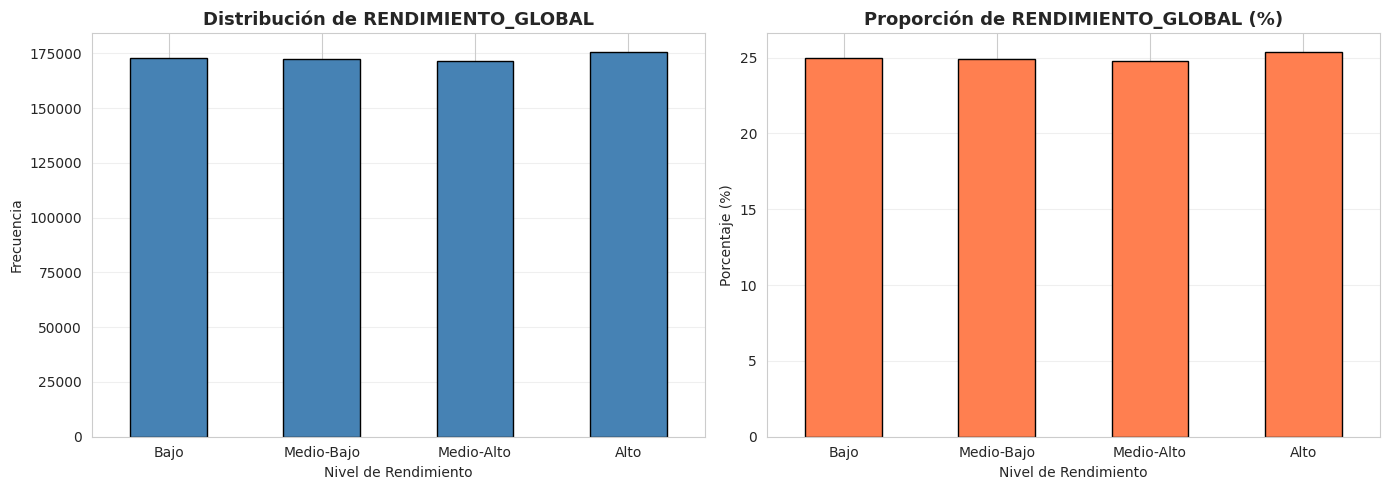

/tmp/ipython-input-2986040150.py:55: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(data_boxplot, labels=labels_boxplot)


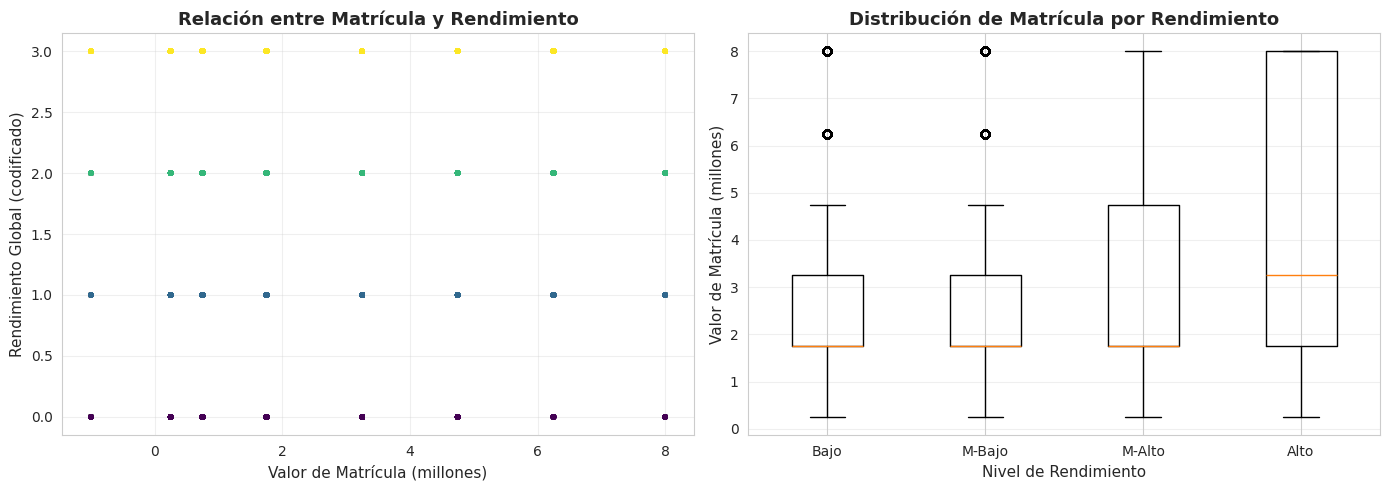

In [ ]:
print("\nGENERANDO VISUALIZACIONES")
print("=" * 80)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

z_procesado['RENDIMIENTO_GLOBAL'].value_counts().sort_index().plot(
    kind='bar', ax=axes[0], color='steelblue', edgecolor='black'
)
axes[0].set_title('Distribución de RENDIMIENTO_GLOBAL', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Nivel de Rendimiento')
axes[0].set_ylabel('Frecuencia')
axes[0].set_xticklabels(['Bajo', 'Medio-Bajo', 'Medio-Alto', 'Alto'], rotation=0)
axes[0].grid(axis='y', alpha=0.3)

(z_procesado['RENDIMIENTO_GLOBAL'].value_counts().sort_index() / len(z_procesado) * 100).plot(
    kind='bar', ax=axes[1], color='coral', edgecolor='black'
)
axes[1].set_title('Proporción de RENDIMIENTO_GLOBAL (%)', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Nivel de Rendimiento')
axes[1].set_ylabel('Porcentaje (%)')
axes[1].set_xticklabels(['Bajo', 'Medio-Bajo', 'Medio-Alto', 'Alto'], rotation=0)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sample_size = min(10000, len(z_procesado))
sample = z_procesado.sample(n=sample_size, random_state=42)

axes[0].scatter(
    sample['E_VALORMATRICULAUNIVERSIDAD'],
    sample['RENDIMIENTO_GLOBAL'],
    alpha=0.3,
    s=10,
    c=sample['RENDIMIENTO_GLOBAL'],
    cmap='viridis'
)
axes[0].set_xlabel('Valor de Matrícula (millones)', fontsize=11)
axes[0].set_ylabel('Rendimiento Global (codificado)', fontsize=11)
axes[0].set_title('Relación entre Matrícula y Rendimiento', fontsize=13, fontweight='bold')
axes[0].grid(alpha=0.3)

data_boxplot = []
labels_boxplot = []
for nivel in sorted(z_procesado['RENDIMIENTO_GLOBAL'].unique()):
    valores = z_procesado[z_procesado['RENDIMIENTO_GLOBAL'] == nivel]['E_VALORMATRICULAUNIVERSIDAD']
    valores_filtrados = valores[valores >= 0]
    if len(valores_filtrados) > 0:
        data_boxplot.append(valores_filtrados)
        labels_boxplot.append({0: 'Bajo', 1: 'M-Bajo', 2: 'M-Alto', 3: 'Alto'}[nivel])

if data_boxplot: # Only attempt to plot if there is data
    axes[1].boxplot(data_boxplot, labels=labels_boxplot)
    axes[1].set_xlabel('Nivel de Rendimiento', fontsize=11)
    axes[1].set_ylabel('Valor de Matrícula (millones)', fontsize=11)
    axes[1].set_title('Distribución de Matrícula por Rendimiento', fontsize=13, fontweight='bold')
    axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 16. Exportación del dataset preprocesado

In [ ]:
print("\nGENERANDO ARCHIVO DE SUBMISSION")
print("=" * 80)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X = z_procesado.drop('RENDIMIENTO_GLOBAL', axis=1)
y = z_procesado['RENDIMIENTO_GLOBAL']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nDimensiones de los sets de datos:")
print(f"  X_train: {X_train.shape}")
print(f"  X_val: {X_val.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  y_val: {y_val.shape}")

print("\nEntrenando modelo RandomForestClassifier...")
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
print("Entrenamiento completado.")

y_pred_val = model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred_val)
print(f"\nPrecisión del modelo en el conjunto de validación: {accuracy:.4f}")


print("\nRealizando predicciones en el dataset de prueba...")
zt_procesado_test = zt_procesado_test[X.columns]
preds_test_data = model.predict(zt_procesado_test)
print("Predicciones completadas.")
print(f"Número de predicciones generadas: {len(preds_test_data):,}")


print("\nGenerando archivo de submission...")

rmap = {
    'bajo': 0,
    'medio-bajo': 1,
    'medio-alto': 2,
    'alto': 3
}
rmapi = {v: k for k, v in rmap.items()}
text_preds_test_data = [rmapi[i] for i in preds_test_data]

submission = pd.DataFrame({'ID': zt_ids, 'RENDIMIENTO_GLOBAL': text_preds_test_data})

output_file = "my_submission.csv"
submission.to_csv(output_file, index=False)

if Path(output_file).exists():
    file_size = Path(output_file).stat().st_size / 1024**2
    print(f"\nArchivo de submission guardado exitosamente: {output_file}")
    print(f"Tamaño del archivo: {file_size:.2f} MB")
    print(f"Dimensiones: {submission.shape[0]:,} filas × {submission.shape[1]} columnas")

    if submission.shape[0] == 296786:
        print("Verificación de número de filas: OK (296,786 filas)")
    else:
        print(f"ADVERTENCIA: Número de filas incorrecto: {submission.shape[0]}")

else:
    print(f"ERROR: No se pudo crear el archivo {output_file}")
print("\nProceso de submission completado.")


GENERANDO ARCHIVO DE SUBMISSION

Dimensiones de los sets de datos:
  X_train: (554000, 12)
  X_val: (138500, 12)
  y_train: (554000,)
  y_val: (138500,)

Entrenando modelo RandomForestClassifier...
Entrenamiento completado.

Precisión del modelo en el conjunto de validación: 0.3674

Realizando predicciones en el dataset de prueba...
Predicciones completadas.
Número de predicciones generadas: 296,786

Generando archivo de submission...

Archivo de submission guardado exitosamente: my_submission.csv
Tamaño del archivo: 3.78 MB
Dimensiones: 296,786 filas × 2 columnas
Verificación de número de filas: OK (296,786 filas)

Proceso de submission completado.


In [ ]:
# Comando para enviar el archivo a la competencia Kaggle
!kaggle competitions submit -c udea-ai-4-eng-20252-pruebas-saber-pro-colombia \
-f my_submission.csv -m "raul ramos submission with linear model"

100% 3.78M/3.78M [00:00<00:00, 16.3MB/s]
Successfully submitted to UDEA/ai4eng 20252 - Pruebas Saber Pro Colombia